In [302]:
import pandas as pd
import numpy as np
from collections import Counter, defaultdict
from sklearn.model_selection import train_test_split
from statsmodels.discrete.discrete_model import Logit
from statsmodels.tools import add_constant
from sklearn.metrics import roc_curve as sk_roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, VotingClassifier

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')

In [195]:
df = pd.read_csv('data/DataminingContest2009.Task2.Train.Inputs')
target = pd.read_csv('data/DataminingContest2009.Task2.Train.Targets')
df = df.merge(target, left_index=True, right_index=True)
df.rename(columns={'0':'fraud'}, inplace=True)
df.head()

,amount,hour1,state1,zip1,custAttr1,field1,custAttr2,field2,hour2,flag1,total,field3,field4,indicator1,indicator2,flag2,flag3,flag4,flag5,fraud
0,12.95,0,WA,986,1234567890123456,0,luhxsodzmjhng7@comcast.net,0,0,0,12.95,-723,19,0,0,0,0,0,1,0
1,38.85,0,WA,980,1234567890123457,3,pfixyiqfpvkcg@zjyxs.net,1,0,0,38.85,5497,14,1,0,0,1,0,1,0
2,38.85,0,KY,402,1234567890123458,2,shbjoldciswwm@aol.com,1,0,0,38.85,-4420,23,0,0,1,1,0,1,0
3,12.95,0,CA,958,1234567890123459,3,ipbvtdfkhhfws@sbcglobal.net,0,0,0,12.95,5010,31,0,0,1,0,0,1,0
4,38.85,0,GA,300,1234567890123460,3,ivfuvxiennhdp@bellsouth.net,1,0,0,38.85,-4074,21,0,0,1,0,0,1,0


In [196]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99999 entries, 0 to 99998
Data columns (total 20 columns):
amount        99999 non-null float64
hour1         99999 non-null int64
state1        99998 non-null object
zip1          99999 non-null int64
custAttr1     99999 non-null int64
field1        99999 non-null int64
custAttr2     99999 non-null object
field2        99999 non-null int64
hour2         99999 non-null int64
flag1         99999 non-null int64
total         99999 non-null float64
field3        99999 non-null int64
field4        99999 non-null int64
indicator1    99999 non-null int64
indicator2    99999 non-null int64
flag2         99999 non-null int64
flag3         99999 non-null int64
flag4         99999 non-null int64
flag5         99999 non-null int64
fraud         99999 non-null int64
dtypes: float64(2), int64(16), object(2)
memory usage: 16.0+ MB


In [197]:
df.describe()

,amount,hour1,zip1,custAttr1,field1,field2,hour2,flag1,total,field3,field4,indicator1,indicator2,flag2,flag3,flag4,flag5,fraud
count,99999.000000,99999.000000,99999.000000,9.999900e+04,99999.000000,99999.000000,99999.00000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.00000,99999.000000
mean,26.976720,14.016050,544.309063,1.234568e+15,2.368264,0.405374,14.03053,0.419714,26.976720,368.757788,15.026200,0.113371,0.017850,0.556406,0.391394,0.013730,16.03750,0.026540
std,14.595024,5.415142,317.287693,2.140153e+04,0.998771,0.490967,5.40947,0.493515,14.595024,4151.207393,6.450303,0.317048,0.132407,0.496811,0.488065,0.116369,191.19551,0.160736
min,0.000000,0.000000,6.000000,1.234568e+15,0.000000,0.000000,0.00000,0.000000,0.000000,-26803.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
25%,12.950000,11.000000,279.000000,1.234568e+15,2.000000,0.000000,11.00000,0.000000,12.950000,-2260.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.00000,0.000000
50%,25.900000,14.000000,535.000000,1.234568e+15,3.000000,0.000000,14.00000,0.000000,25.900000,1093.000000,15.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.00000,0.000000
75%,38.850000,18.000000,891.000000,1.234568e+15,3.000000,1.000000,18.00000,1.000000,38.850000,3517.000000,20.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.00000,0.000000
max,59.950000,23.000000,999.000000,1.234568e+15,4.000000,1.000000,23.00000,1.000000,59.950000,8169.000000,44.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3278.00000,1.000000


#### right off the bat it looks like there were purchases entered as $0 -- these will likely need to be deleted, presumably owing to input error
#### it's also worth noting that 2.65 % of all transactions are fraud
#### who knows what our flags and indicators are but my suspicion is that indicator2 and flag4 have stronger correlation with fraud as their means are closest

In [198]:
df.isna().sum()

amount        0
hour1         0
state1        1
zip1          0
custAttr1     0
field1        0
custAttr2     0
field2        0
hour2         0
flag1         0
total         0
field3        0
field4        0
indicator1    0
indicator2    0
flag2         0
flag3         0
flag4         0
flag5         0
fraud         0
dtype: int64

In [199]:
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

In [200]:
df = df[df.amount != 0]
df.reset_index(drop=True, inplace=True)

In [201]:
#check that we can drop one or the other
df[df.amount != df.total]

,amount,hour1,state1,zip1,custAttr1,field1,custAttr2,field2,hour2,flag1,total,field3,field4,indicator1,indicator2,flag2,flag3,flag4,flag5,fraud


In [202]:
df.pop('total')

0        12.95
1        38.85
2        38.85
3        12.95
4        38.85
         ...  
98090    25.90
98091    31.08
98092    49.95
98093    11.01
98094    12.95
Name: total, Length: 98095, dtype: float64

In [203]:
df[df.hour1 != df.hour2]

,amount,hour1,state1,zip1,custAttr1,field1,custAttr2,field2,hour2,flag1,field3,field4,indicator1,indicator2,flag2,flag3,flag4,flag5,fraud
76,38.85,7,OH,454,1234567890123525,3,brtjtphsbisqb@paradigmasset.com,0,8,0,-3166,8,0,0,1,1,0,2,0
109,34.97,8,VA,201,1234567890123557,3,mqbomhkvofshy@lycos.com,0,9,1,-1965,7,0,0,0,0,0,1,0
465,12.95,16,TX,761,1234567890123892,3,dvirbnkgkitlk2@aol.com,1,15,0,1065,15,0,0,1,1,0,1,0
467,49.95,16,GA,303,1234567890123893,2,vqzakxmdkigem@bellsouth.net,1,15,0,-6674,21,0,0,0,0,0,1,0
508,38.85,16,IN,474,1234567890123932,3,wjhmtjmxmskmp17@yahoo.com,1,17,0,2925,20,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97731,38.85,9,AL,357,1234567890161728,3,atgthpjcjcoww@ngc.com,1,10,1,4063,8,0,0,1,0,0,1,0
97866,49.95,12,AZ,852,1234567890197026,3,phpqriqrmubjz@hotmail.com,0,11,0,3926,9,1,0,1,1,0,2,0
97939,38.85,12,CA,941,1234567890197084,3,vtajtzawnxucb@yahoo.com,0,13,1,114,8,0,0,1,1,0,1,0
97943,38.85,12,FL,331,1234567890197087,2,yommholfyihtn99@aol.com,1,13,0,-4629,16,1,0,1,1,0,1,0


In [204]:
df = df[df.hour1 == df.hour2]
df.pop('hour2')
df.rename(columns={'hour1':'hour'},inplace=True)
df.reset_index(drop=True, inplace=True)

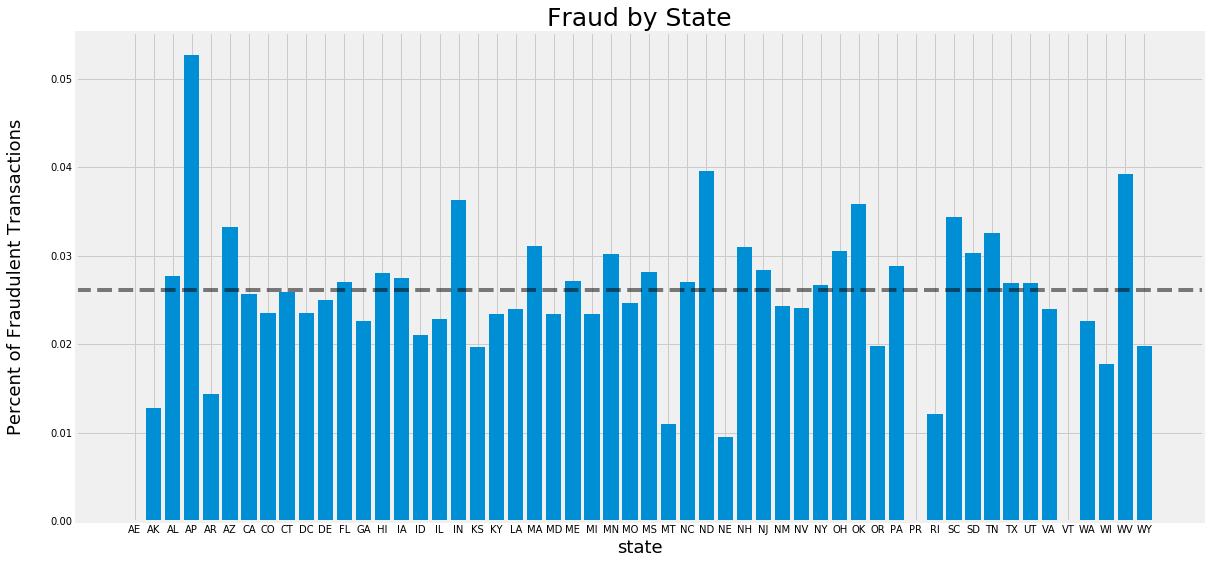

In [205]:
'''fig, ax = plt.subplots(figsize=(18, 9))
likes = df.groupby('state1').fraud.mean()
ax.set_title('Fraud by State', fontsize=25)
ax.set_xlabel('state', fontsize=18)
ax.set_ylabel('Percent of Fraudulent Transactions', fontsize=18, labelpad=25)
ax.axhline(df.fraud.mean(), color='k', linestyle='--', alpha=.5)
ax.bar(likes.index, likes)
fig.savefig('visuals/fraudbystate.png')'''

In [206]:
df.pop('state1')

In [237]:
df['custAttr2'] = df['custAttr2'].apply(lambda s: s.split('@')[-1])
df.rename(columns={'custAttr2':'email', 'custAttr1':'account_id'},inplace=True)

In [366]:
def simple_fields(df, field):
    d = defaultdict(list)
    categories = df[field].unique()
    for cat in categories:
        fm = df[df[field] == cat].fraud.mean()
        if fm  == 0:
            d['legal'].append(cat)
        else:
            d['fraud'].append({cat:fm})
            
    return d

In [367]:
simple_fields(df, 'indicator2')

defaultdict(list,
            {'fraud': [{0: 0.0261717341028198}, {1: 0.02376599634369287}]})

### CREATE VALIDATION DATASET

In [185]:
test_mask = np.random.choice(np.arange(df.shape[0]), 30000, replace=False)

In [186]:
train_mask = np.delete(np.arange(df.shape[0]), test_mask)

In [241]:
test_df, train_df = df.iloc[test_mask], df.iloc[train_mask]

In [190]:
train_df.describe()

,amount,hour,zip1,custAttr1,field1,field2,flag1,field3,field4,indicator1,indicator2,flag2,flag3,flag4,flag5,fraud
count,65903.000000,65903.000000,65903.000000,6.590300e+04,65903.000000,65903.000000,65903.000000,65903.000000,65903.00000,65903.000000,65903.000000,65903.000000,65903.000000,65903.000000,65903.000000,65903.000000
mean,27.451122,14.032882,544.475320,1.234568e+15,2.340485,0.404913,0.427568,390.160069,15.02091,0.112848,0.016964,0.556439,0.388116,0.014203,1.741089,0.026008
std,14.232632,5.446482,317.870791,2.142595e+04,0.979416,0.490879,0.494730,4130.425774,6.46646,0.316409,0.129139,0.496808,0.487325,0.118327,38.871277,0.159160
min,9.500000,0.000000,6.000000,1.234568e+15,0.000000,0.000000,0.000000,-23510.000000,6.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,12.950000,11.000000,278.000000,1.234568e+15,2.000000,0.000000,0.000000,-2225.000000,9.00000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,31.080000,14.000000,534.000000,1.234568e+15,3.000000,0.000000,0.000000,1110.000000,15.00000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,38.850000,18.000000,891.000000,1.234568e+15,3.000000,1.000000,1.000000,3533.500000,20.00000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000
max,59.950000,23.000000,999.000000,1.234568e+15,4.000000,1.000000,1.000000,8169.000000,44.00000,1.000000,1.000000,1.000000,1.000000,1.000000,3278.000000,1.000000


In [242]:
test_df.to_csv('data/validation.csv', index=False)
train_df.to_csv('data/train.csv', index=False)

In [80]:
train_df.field2.value_counts()

0    58390
1    39705
Name: field2, dtype: int64

In [81]:
train_df.head()

,amount,hour1,state1,zip1,custAttr1,field1,custAttr2,field2,hour2,flag1,total,field3,field4,indicator1,indicator2,flag2,flag3,flag4,flag5,fraud
0,12.95,0,WA,986,1234567890123456,0,luhxsodzmjhng7@comcast.net,0,0,0,12.95,-723,19,0,0,0,0,0,1,0
1,38.85,0,WA,980,1234567890123457,3,pfixyiqfpvkcg@zjyxs.net,1,0,0,38.85,5497,14,1,0,0,1,0,1,0
2,38.85,0,KY,402,1234567890123458,2,shbjoldciswwm@aol.com,1,0,0,38.85,-4420,23,0,0,1,1,0,1,0
3,12.95,0,CA,958,1234567890123459,3,ipbvtdfkhhfws@sbcglobal.net,0,0,0,12.95,5010,31,0,0,1,0,0,1,0
4,38.85,0,GA,300,1234567890123460,3,ivfuvxiennhdp@bellsouth.net,1,0,0,38.85,-4074,21,0,0,1,0,0,1,0


In [192]:
df.head()

,amount,hour,zip1,custAttr1,field1,custAttr2,field2,flag1,field3,field4,indicator1,indicator2,flag2,flag3,flag4,flag5,fraud
0,12.95,0,986,1234567890123456,0,luhxsodzmjhng7@comcast.net,0,0,-723,19,0,0,0,0,0,1,0
1,38.85,0,980,1234567890123457,3,pfixyiqfpvkcg@zjyxs.net,1,0,5497,14,1,0,0,1,0,1,0
2,38.85,0,402,1234567890123458,2,shbjoldciswwm@aol.com,1,0,-4420,23,0,0,1,1,0,1,0
3,12.95,0,958,1234567890123459,3,ipbvtdfkhhfws@sbcglobal.net,0,0,5010,31,0,0,1,0,0,1,0
4,38.85,0,300,1234567890123460,3,ivfuvxiennhdp@bellsouth.net,1,0,-4074,21,0,0,1,0,0,1,0


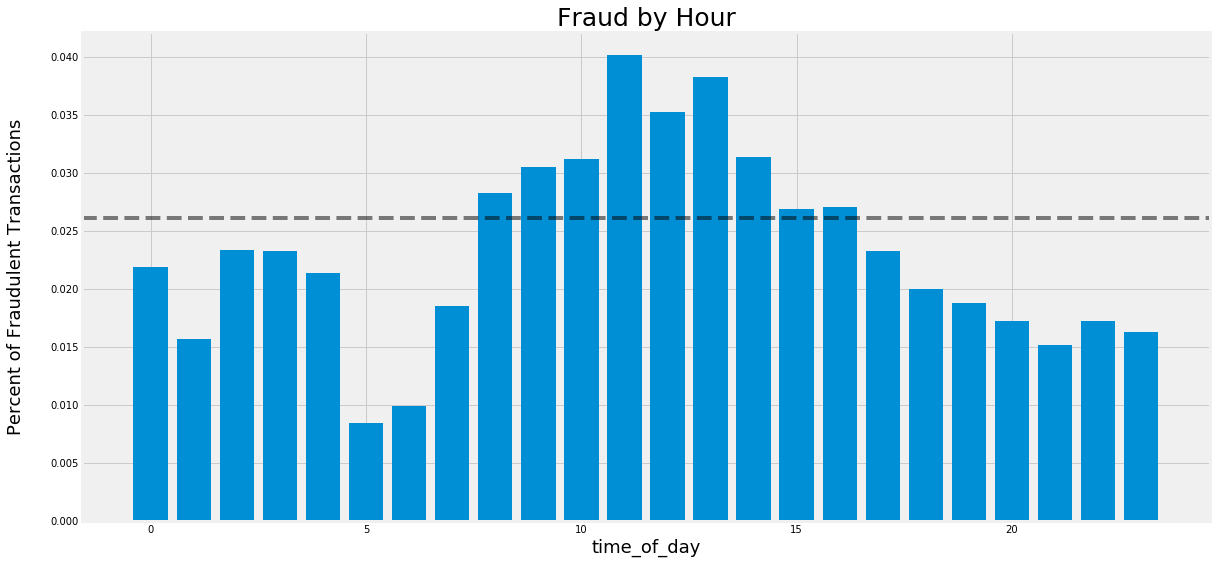

In [207]:
fig, ax = plt.subplots(figsize=(18, 9))
likes = df.groupby('hour').fraud.mean()
ax.set_title('Fraud by Hour', fontsize=25)
ax.set_xlabel('time_of_day', fontsize=18)
ax.set_ylabel('Percent of Fraudulent Transactions', fontsize=18, labelpad=25)
ax.axhline(df.fraud.mean(), color='k', linestyle='--', alpha=.5)
ax.bar(likes.index, likes)
#fig.savefig('visuals/fraudbyhour.png')

In [219]:
user_mask = df.custAttr1.value_counts()[(df.custAttr1.value_counts() > 1)].index

In [231]:
single_purchases = df[df.custAttr1.isin(user_mask)]
multiple_purchases = df[~df.custAttr1.isin(user_mask)]
single_counts = single_purchases.shape[0]
multiple_counts = multiple_purchases.shape[0]
single_prob = single_purchases.fraud.mean()
multi_prob = multiple_purchases.fraud.mean()

In [232]:
pd.DataFrame(data={'Number of Purchases': [single_counts, multiple_counts],
              'Percent of Fraud': [single_prob, multi_prob]},
             index=['Single Transaction', 'Multiple Transactions'])

,Number of Purchases,Percent of Fraud
Single Transaction,39833,0.026812
Multiple Transactions,56070,0.025647


In [252]:
e_mask

Index(['qumzwxovugnb.com', 'vgzqq.edu', 'libvvzfuhzlm.com', 'ovpk.com',
       'ruupfdxinlecktx.com', 'vdmjzczputv.com', 'mbojhodcjiqeuwx.com',
       'cprpssgekxowvpk.com', 'xwjcpyfcdmbtlrn.com', 'lfehfpi.com',
       ...
       'zrnixuwu.com', 'mdvwuutumn.com', 'rxnuenavbvfmtssmkuls.com',
       'etvjsha.com', 'ysyxfu.net', 'qqrnhr.com', 'nbdlibrmchfavgynwni.net',
       'jpfzidacddz.com', 'giqikphmlze.com', 'jmnsq.com'],
      dtype='object', length=7108)

In [240]:
df.head()

,amount,hour,zip1,account_id,field1,email,field2,flag1,field3,field4,indicator1,indicator2,flag2,flag3,flag4,flag5,fraud
0,12.95,0,986,1234567890123456,0,comcast.net,0,0,-723,19,0,0,0,0,0,1,0
1,38.85,0,980,1234567890123457,3,zjyxs.net,1,0,5497,14,1,0,0,1,0,1,0
2,38.85,0,402,1234567890123458,2,aol.com,1,0,-4420,23,0,0,1,1,0,1,0
3,12.95,0,958,1234567890123459,3,sbcglobal.net,0,0,5010,31,0,0,1,0,0,1,0
4,38.85,0,300,1234567890123460,3,bellsouth.net,1,0,-4074,21,0,0,1,0,0,1,0


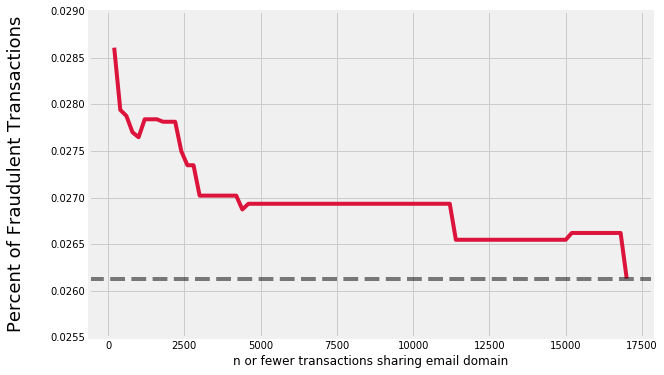

In [277]:

e_g = range(200, 17100, 200)
f = []
for c in e_g:
    e_mask = df.email.value_counts()[(df.email.value_counts() <= c)].index
    f.append(df[df.email.isin(e_mask)].fraud.mean())
fig, ax = plt.subplots(figsize=(9,6))
ax.plot(e_g, f, c='crimson')
ax.axhline(df.fraud.mean(), color='k', linestyle='--', alpha=.5)
ax.set_ylim([.0255, .029])
ax.set_xlabel('n or fewer transactions sharing email domain')
ax.set_ylabel('Percent of Fraudulent Transactions', fontsize=18, labelpad=25);

In [306]:
e_dict = defaultdict()
email_counts = df.email.value_counts()
for count in set(email_counts):
    e_mask = email_counts[email_counts==count].index
    fraud_rate = df[df.email.isin(e_mask)].fraud.mean()
    e_dict[count] = fraud_rate

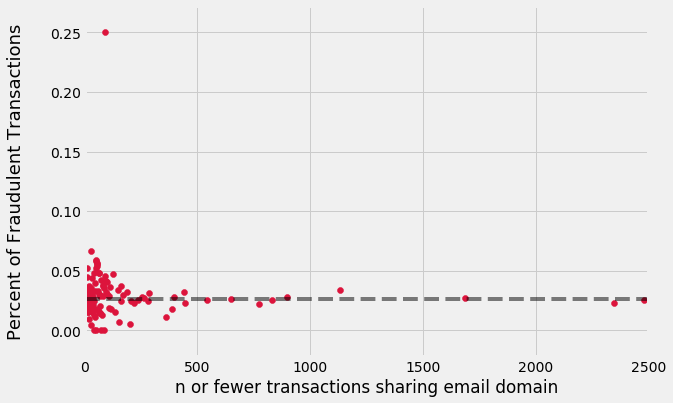

In [316]:
fig, ax = plt.subplots(figsize=(9,6))
ax.scatter(list(e_dict.keys()), list(e_dict.values()), c='crimson')
ax.axhline(df.fraud.mean(), color='k', linestyle='--', alpha=.5)
ax.set_xlim([0, 2500])
ax.set_xlabel('n or fewer transactions sharing email domain')
ax.set_ylabel('Percent of Fraudulent Transactions', fontsize=18, labelpad=25);

In [279]:
top_domains = ['aol.com', 'yahoo.com', 'hotmail.com', 'comcast.net', 'msn.com']
for d in top_domains:
    print (d)
    print (df[df.email == d].fraud.mean())
    

aol.com
0.023832164507310117
yahoo.com
0.0269315378974735
hotmail.com
0.024738428799432523
comcast.net
0.02758164165931156
msn.com
0.025354733658990464


In [319]:
email_counts[email_counts==92]

clintmiller.com    92
Name: email, dtype: int64

In [331]:
df.groupby('email').fraud.mean()[df.groupby('email').fraud.mean() < 1].sort_values(ascending=False)[15:30]

email
extremezone.com       0.5
hmirffbjf.com         0.5
dzcedadhfjrx.com      0.5
kevnhtna.com          0.5
tyiuheoyyu.net        0.5
gqqfgtvnezr.com       0.5
lsoiensonho.com       0.5
wsbxnxsbq.com         0.5
ntzx.harvard          0.5
gqch.org              0.5
bblndvemgefhvy.com    0.5
iwoulavce.com         0.5
mhzzltbwkhtj.net      0.5
qyshvrvstz.net        0.5
kadena.af.mil         0.5
Name: fraud, dtype: float64

In [332]:
df[df.email == 'extremezone.com']

,amount,hour,zip1,account_id,field1,email,field2,flag1,field3,field4,indicator1,indicator2,flag2,flag3,flag4,flag5,fraud
14481,38.85,17,852,1234567890135796,3,extremezone.com,0,0,-9109,9,0,0,1,0,0,1,1
74683,38.85,13,850,1234567890181610,3,extremezone.com,0,0,-8805,19,0,0,0,0,0,1,0


In [344]:
df.flag5.unique()

array([   1,    2,    4,    3,    5,    9, 1434,    8,    7,   98, 3278,
          0,  364,    6, 1600,  100, 1643])

In [352]:
df[df.flag5 == 5].fraud.mean()

0.0